# Comparing Quality Metrics: *Source Coverage Ratio (SCR)* and *Harvest*

In [81]:
# a little setting up to get started
%matplotlib inline
import math
import heapq
import random
import numpy as np
import itertools as it
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid.axislines import Subplot
import seaborn as sns
sns.set_style("whitegrid")

### Quality Metrics
**Harvest** is calculated as the total number of distinct sources from which at least a tuple has been received.  
>The fraction of data sources represented in an answer to a query.
>Harvest represents the coverage of a query result and is negatively affected by failures or loss within the query tree. Note that harvest is not directly related to correctness, since a result with
>a harvest of 100% can still experience errors due to
>state divergence of operators. However, a high value
>for harvest indicates good confidence that the answer represents all of the input data sources"

From [*"Towards a Dependable Architecture for Internet-scale Sensing*](https://www.usenix.org/legacy/events/hotdep06/tech/prelim_papers/murty/murty.pdf) (page 4)

**Source Coverage Ratio** is calculated by summing the individual contributions of all receveid tuples.

$$ SCR_i = \sum{1 \over |T^{S}_{i}|}$$

Where $|T^{S}_{i}|$ is the total amount of *tuples* produced by source $S$ during interval $i$.
Each tuples carries a SCR value that is the inverse of the total amount of tuples produced by that source at the current timestep. In the original SCR formulation this values is also normalised by the number of sources, so that the metric lies in the [0,1] interval. For this set of experiments the normalisation is left out to allow a direct comparison between *Harvest* and *SCR* as they both lie in the [0, num_sources] interval.

In [82]:
def calculate_harvest(tuples):
    """Counts the number of different received `source_id`"""
    return len(set([t['source_id'] for t in tuples]))

def calculate_scr(tuples):
    """Sums the SCR values of all tuples"""
    return sum([t['scr'] for t in tuples])

### Random Functions
Functions to sample a random array from a distribution. These are used to generate rates for the sources, so that it 
is possible to compare the impact of shedding on the quality metrics for a number of different distributions of source's rate. They are also used to generate the payload value of the tuples, by default from mixture of *constant*, *uniform*, *normal* and *zipf*. 

In [83]:
# functions to sample a random array from a distribution

def array_constant(num_samples, mean_value=50):
    """All values set to `mean_value`"""
    return np.full(num_samples, mean_value, dtype='int32')

def array_uniform(num_samples, mean_value=50):
    """Values are drawn uniformly in the interval [1, `mean_value`]"""
    return np.random.randint(1, 1+2*mean_value, num_samples)

def array_normal(num_samples, mean_value=50, sigma=10):
    """Values are drawn from a normal distibution with `mean_value` and `sigma`"""
    return np.round(np.random.normal(mean_value, sigma, num_samples))

def array_zipf(num_samples, mean_value=50, alpha=2):
    """Values are drawn from a zipf distibution with `alpha`, then scaled to have mean of `mean_value`"""
    zipf = np.random.zipf(alpha, num_samples)
    return np.ceil(zipf * (mean_value / np.mean(zipf))).astype('int32')

def array_mixed(num_samples, **kwargs):
    """Values are drawn from a mixture of all distributions"""
    fn_dists = [array_constant, array_uniform, array_normal, array_zipf]
    # divide the total in as many classes as distributions at random
    allocations = np.random.random(len(fn_dists))
    allocations= np.round(total * allocations / np.sum(allocations)).astype('int32')
    # for each source rate distribution draw the allocated number of tuples
    all_tuples = []
    for i, fn in enumerate(fn_dists):
        all_tuples += list(fn(allocations[i],**kwargs))
    return all_tuples

### Tuple Generation
Each tuple is a dictionary with keys:
  - *source_id*: source identifier, for Harvest
  - *SCR*: source coverage ratio tuple contribution
  - *payload*: a scalar value drawn from a distribution


In [84]:
def generate_tuples(source_rates, value_fn, **kwargs):
    """`source_rates`: np.array of rates for each source 
       `value_fn`: function that emits tuple values drawn from a distribution
                         
        Returns a list of dictionaries, each representing a tuple
        with it's associated `source_id`, `value` and `SCR` metadata
    """
    all_tuples = []
    for source_id, n_tuples in enumerate(source_rates):
        # emit tuples for each source
        tuple_values = value_fn(n_tuples, **kwargs)
        tuples = [{'source_id': source_id,
                   # SCR value is not divided by the number of sources for comparison
                   # this makes it lie in the same interval as harvest [0, num_sources]
                   'scr': 1 / n_tuples,
                   'value': x} for x in tuple_values]
        all_tuples += tuples
    return all_tuples

### Query Functions
A variety of sample queries to be run on the generated tuples, to show the effect of tuple shedding on their and compare the degraded quality metric. Aggregate queries, such as *avegrage*, do not suffer much from load-shedding, others degrade their quality linearly with the amount of tuples dropped like *topK* and *count*, *covariance* follows a degrading trend but never go completely to zero.

In [85]:
def count_query(tuples):
    """Count the number of tuples"""
    return len(tuples)

def avg_query(tuples):
    """Calculates the average of all tuples' `value` """
    return np.mean(np.array([t['value'] for t in tuples]))

def topk_query(tuples, k):
    """Returns the highest K of all tuples' `value`"""
    return heapq.nlargest(k, [t['value'] for t in tuples])

def cov_query(tuples):
    """Calculates the covariance of all tuples' `value`"""
    return np.cov(np.array([t['value'] for t in tuples]))

### Error Functions
Functions to compare a perfect query result in absence of tuple shedding with the result obtained from a degraded tuple list.

In [86]:
def absolute_error(perfect, degraded):
    """Calculate absolute error"""
    return abs(perfect - degraded) / perfect

def topk_hit(perfect, degraded):
    """How many elements of degraded are in the perfect list"""
    return len([x for x in degraded if x in set(perfect)]) / len(perfect)

def kendall_tau(perfect, degraded):
    """Kendall Tau correlation"""
    tau, pvalue = stats.kendalltau(perfect, degraded)
    return tau

def topk_distance(perfect, degraded):
    """Number of pairs that are missing from the degraded list
    divided by the total number of pairs in the perfect lits"""
    cmb_perf = set(it.combinations(perfect, 2))
    cmb_degr = set(it.combinations(degraded, 2))
    intersect = set(cmb_perf & cmb_degr)
    return absolute_error(len(cmb_perf), len(intersect))

### Shedding Logic
Functions to simulate tuple shedding. Given a list of tuples, it generates a number of data points to be plotted: the quality metrics values at different amounts of tuple dropping.
The range of shedding, from 0 to 100%, is divided into a number of steps (by default 5%) and for each shedding rate a simulation is run for a number of iterations. At each time step the quality and query values are calculated and compared with their perfect value in absence of shedding. An average over all iterations is reported for shedding step, so that it's possible to visualise how the query results degrade in relation to the amount of tuple shedding.  
The quality values, *SCR* and *Harvest*, are later plotted against the tuple shedding percentage. 


In [87]:
def shed(tuples, percent):
    """Drop a certain `percent` of all `tuples`"""
    random.shuffle(tuples)
    n_drop = int(len(tuples) * percent / 100)
    return tuples[n_drop:]

def do_one_timestep(tuples, shed_rate, topk=20):
    """Shed a certain percentage of tuples and calculate metadata and query values"""
    
    shedded_tuples = shed(tuples, shed_rate)
    
    scr = calculate_scr(shedded_tuples)
    harvest = calculate_harvest(shedded_tuples)
    
    err_avg_query = absolute_error(avg_query(tuples), avg_query(shedded_tuples))
    err_cov_query = absolute_error(cov_query(tuples), cov_query(shedded_tuples))
    err_count_query = absolute_error(count_query(tuples), count_query(shedded_tuples))
    err_topk_query = topk_distance(topk_query(tuples, topk), topk_query(shedded_tuples, topk))

    return dict(scr=scr,
                harvest=harvest,
                err_avg_query=err_avg_query,
                err_cov_query=err_cov_query,
                err_count_query=err_count_query,
                err_topk_query=err_topk_query)

def avg_key(records, key):
    """Calculate the average value of a key in a list of dictionaries"""
    return sum([x[key] for x in records]) / len(records)

def simulate_shedding_rate(tuples, shed_rate, timesteps):
    """Run a number of simulated `timesteps`, shedding a percentage of tuples and calculating metrics"""
    samples = [do_one_timestep(tuples, shed_rate) for x in range(timesteps)]
    avg_scr = avg_key(samples, 'scr')
    avg_harvest = avg_key(samples, 'harvest')
    err_avg_query = avg_key(samples, 'err_avg_query')
    err_cov_query = avg_key(samples, 'err_cov_query')
    err_count_query = avg_key(samples, 'err_count_query')
    err_topk_query = avg_key(samples, 'err_topk_query')
    # print a summary for this tuple dropping rate
    print('%d%%\t\t%.2f\t\t%.2f\t\t%.3f\t\t%.2f\t\t%.2f\t\t%.2f' % (shed_rate, avg_scr, avg_harvest, err_avg_query, err_count_query, err_cov_query, err_topk_query))
    return dict(shed_rate=shed_rate, avg_scr=avg_scr, avg_harvest=avg_harvest)

def run_all(tuples, timesteps, num_data_points=20):
    """Calculate the quality metric and query results averages over a number of `timesteps`
       It divides the tuple shedding spectrum [0%, 100%] in a `num_data_points` to be plotted
    """
    # header
    print('Shed\t\tSCR\t\tHarvest\t\terr_AVG\t\terr_Count\terr_COV\t\terr_TopK')
    # calculate all points
    step = math.floor(100 / num_data_points)
    return [simulate_shedding_rate(tuples, shed_rate, timesteps)
            for shed_rate in range(0, 100, step)]

In [88]:
# some utility functions
def dist_plot(arr, bins, kde=False):
    return sns.distplot(arr, bins, kde)

def print_stats(arr):
    print()
    print('Total Tuples:\t%s' % arr.sum())
    print('Average Rate:\t%s' % arr.mean())
    print('Minimum Rate:\t%s' % arr.min())
    print('Maximum Rate:\t%s' % arr.max())
    print('Tuple Rates:')
    print(arr)
    print()

### Experimental Setup

In [89]:
# what tuple rates should be evaluated?
# parameter to the source rate distribution functions
# each produces a Harvest and SCR line in a plot
mean_tuple_rates = [1, 5, 50]

# how many sources to consider?
num_sources = 100

# how many iterations to average? 
timesteps = 10

# what is the mean value carried by a tuple?
mean_tuple_value = 42

### Showtime

In [90]:
def run_source_rate_distribution(sources_rate_fn, name):
    """Utility wrapper function to simplify testing different source rate distributions"""
    
    # matplotlib setup
    fig=plt.figure(1,(13,10))
    ax=Subplot(fig,111)
    fig.add_subplot(ax)

    # run for different tuple rates
    for rate in mean_tuple_rates:
        
        # generate set of sources, each element is the source's rate
        sources_rate = sources_rate_fn(num_sources, rate)

        # generate tuples
        tuples = generate_tuples(sources_rate, array_normal, mean_value=mean_tuple_value)

        # run simulation
        points = run_all(tuples, timesteps, num_data_points=20)

        # plot SCR and Harvest
        shed_rates = [x['shed_rate'] for x in points]
        avg_scr = [x['avg_scr'] for x in points]
        avg_harvest = [x['avg_harvest'] for x in points]
        harvest = ax.plot(shed_rates, avg_harvest, '--', label='Harvest - %s tuple/sec' % rate)
        scr = ax.plot(shed_rates, avg_scr, label='SCR - %s tuple/sec' % rate)
        # final reporting of sources distribution stats
        print_stats(sources_rate)

    # Naming
    plt.ylim([0, max(avg_harvest) * 1.2])
    plt.title('Quality-metrics at different shedding rates - Sources: %s - %s' % (num_sources, name))
    plt.ylabel('Quality')
    plt.xlabel('Shedding Rate')

    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    xticks = mtick.FormatStrFormatter(fmt)
    ax.xaxis.set_major_formatter(xticks)
    plt.legend()
    plt.show()

### Source Rate Distribution: *Constant*
Each source produces exactly the same amount of tuples.

This is the most extreme of the considered scenarios, but also the one the more clearly show the difference between *SCR* and *Harvest*.  
When the source rate is set to 1, the total number of tuples is equal to the number of sources, hence the total number of received tuples is equal to the *Harvest* value. This is also the value of *SCR* since each tuples is assigned an individual value of 1/1. In this case the two metric are in fact the same.  
As the number of tuples produced per tuples increases though, the divergence between the metrics also widens.
When the constant rate it brought up to 5 the Harvest line starts to become bent, slowing down its reduction as the tuple dropping amount increases.  
In a high rate scenario, i.e. 100, the *Harvest* line is at the other extreme, almost a flat line at *num_sources*, its perfect score. This is explained by the fact that the more tuples a source produces, the higher the chances for at least one of the to survive dropping. In this case *Harvest* is almost unaffected by tuple shedding and thus does not correlate at all with the quality experienced by the queries.

*SCR* closely follows the percentage of tuples dropped for all source rate distributions. 


Shed		SCR		Harvest		err_AVG		err_Count	err_COV		err_TopK
0%		100.00		100.00		0.000		0.00		0.00		0.00
5%		95.00		95.00		0.004		0.05		0.02		0.03
10%		90.00		90.00		0.006		0.10		0.03		0.13
15%		85.00		85.00		0.010		0.15		0.04		0.14
20%		80.00		80.00		0.009		0.20		0.05		0.25
25%		75.00		75.00		0.009		0.25		0.08		0.24
30%		70.00		70.00		0.012		0.30		0.07		0.34
35%		65.00		65.00		0.017		0.35		0.10		0.26
40%		60.00		60.00		0.020		0.40		0.10		0.37
45%		55.00		55.00		0.014		0.45		0.12		0.51
50%		50.00		50.00		0.016		0.50		0.14		0.50
55%		45.00		45.00		0.013		0.55		0.15		0.61
60%		40.00		40.00		0.027		0.60		0.17		0.61
65%		35.00		35.00		0.020		0.65		0.12		0.71
70%		30.00		30.00		0.019		0.70		0.22		0.80
75%		25.00		25.00		0.028		0.75		0.29		0.80
80%		20.00		20.00		0.036		0.80		0.18		0.87
85%		15.00		15.00		0.042		0.85		0.34		0.90
90%		10.00		10.00		0.071		0.90		0.35		0.94
95%		5.00		5.00		0.070		0.95		0.46		1.00

Total Tuples:	100
Average Rate:	1.0
Minimum Rate:	1
Maximum Rate:	1
Tuple Rates:
[1 

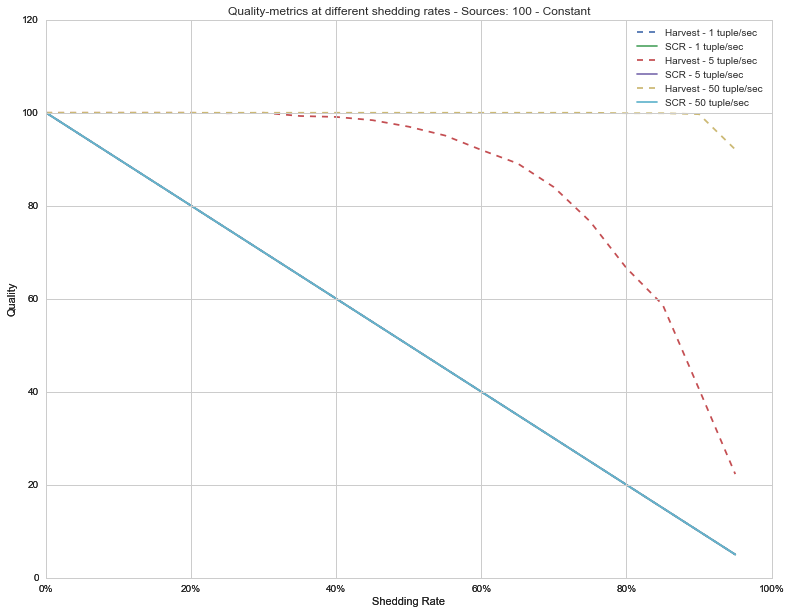

In [91]:
run_source_rate_distribution(array_constant, 'Constant')

### Source Rate Distribution: *Uniform*
Each source emits tuples at a rate drawn from a uniform distribution in the interval [0, 2*mean_rate]  

This is a more realistic scenario in which there is each source emits tuples at a slightly different rate.  
As for the constant rate scenario, *Harvest* changes less when the rate increases, taking a hit only at severe tuple dropping percentages.


Shed		SCR		Harvest		err_AVG		err_Count	err_COV		err_TopK
0%		100.00		100.00		0.000		0.00		0.00		0.00
5%		95.65		98.30		0.003		0.05		0.02		0.05
10%		90.45		95.50		0.005		0.10		0.05		0.10
15%		85.70		92.50		0.007		0.14		0.04		0.06
20%		80.75		89.90		0.008		0.20		0.06		0.25
25%		75.50		86.20		0.010		0.25		0.05		0.25
30%		70.55		81.50		0.006		0.29		0.05		0.37
35%		65.40		77.50		0.010		0.35		0.09		0.41
40%		60.10		73.10		0.009		0.40		0.12		0.44
45%		55.50		68.90		0.018		0.44		0.09		0.36
50%		50.80		64.20		0.013		0.50		0.14		0.51
55%		44.85		57.80		0.017		0.55		0.07		0.61
60%		40.40		53.40		0.012		0.59		0.13		0.72
65%		35.15		46.40		0.019		0.65		0.13		0.70
70%		31.40		41.70		0.029		0.70		0.11		0.76
75%		25.55		35.70		0.039		0.75		0.17		0.87
80%		20.70		29.20		0.023		0.80		0.15		0.85
85%		15.05		22.30		0.034		0.85		0.17		0.93
90%		10.05		15.70		0.044		0.90		0.26		0.94
95%		5.25		7.80		0.087		0.95		0.55		0.99

Total Tuples:	153
Average Rate:	1.53
Minimum Rate:	1
Maximum Rate:	2
Tuple Rates:
[2

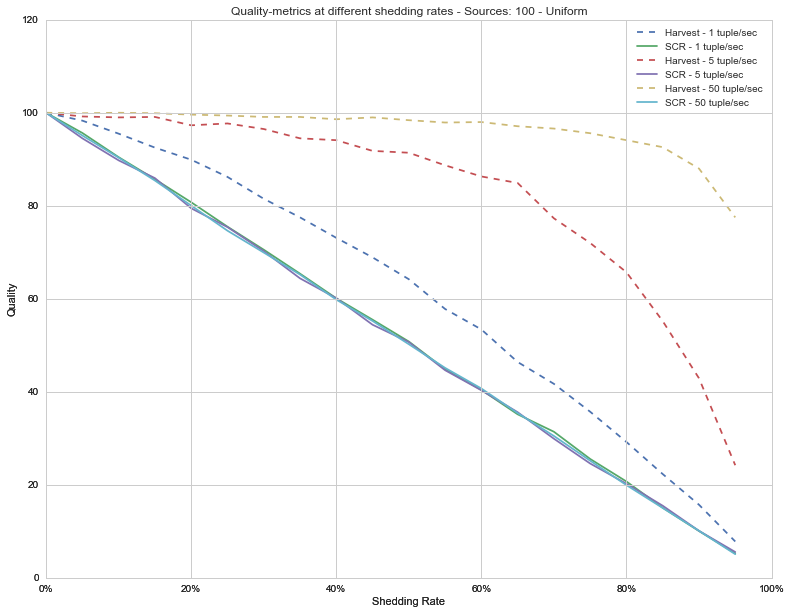

In [92]:
run_source_rate_distribution(array_uniform, 'Uniform')

### Source Rate Distribution: *Zipf*

Each source emits tuples at a rate drawn from a zipf distribution, rescaled to have the required *mean*.  

This scenario models a situation in which all sources are emitting a low number of tuples, while a few outlier produce a much larger volume.  
The results are similar to the 'uniform' setup.

Shed		SCR		Harvest		err_AVG		err_Count	err_COV		err_TopK
0%		100.00		100.00		0.000		0.00		0.00		0.00
5%		95.39		95.80		0.003		0.05		0.01		0.04
10%		91.35		92.60		0.005		0.10		0.04		0.06
15%		84.71		86.30		0.003		0.15		0.05		0.17
20%		79.97		81.90		0.003		0.20		0.07		0.23
25%		76.08		78.70		0.009		0.25		0.06		0.11
30%		68.25		71.30		0.009		0.30		0.08		0.27
35%		65.84		69.10		0.011		0.35		0.10		0.36
40%		60.60		64.20		0.010		0.40		0.11		0.36
45%		56.41		60.40		0.014		0.45		0.12		0.56
50%		50.73		55.00		0.009		0.50		0.07		0.54
55%		45.39		50.00		0.009		0.55		0.10		0.53
60%		41.57		46.50		0.013		0.60		0.14		0.61
65%		35.15		39.70		0.014		0.65		0.16		0.72
70%		28.87		33.60		0.024		0.70		0.18		0.74
75%		24.49		29.10		0.022		0.75		0.16		0.76
80%		18.90		23.00		0.029		0.80		0.13		0.82
85%		15.15		19.90		0.043		0.85		0.21		0.90
90%		10.89		14.20		0.029		0.90		0.42		0.97
95%		5.44		8.10		0.061		0.95		0.24		0.99

Total Tuples:	175
Average Rate:	1.75
Minimum Rate:	1
Maximum Rate:	41
Tuple Rates:
[

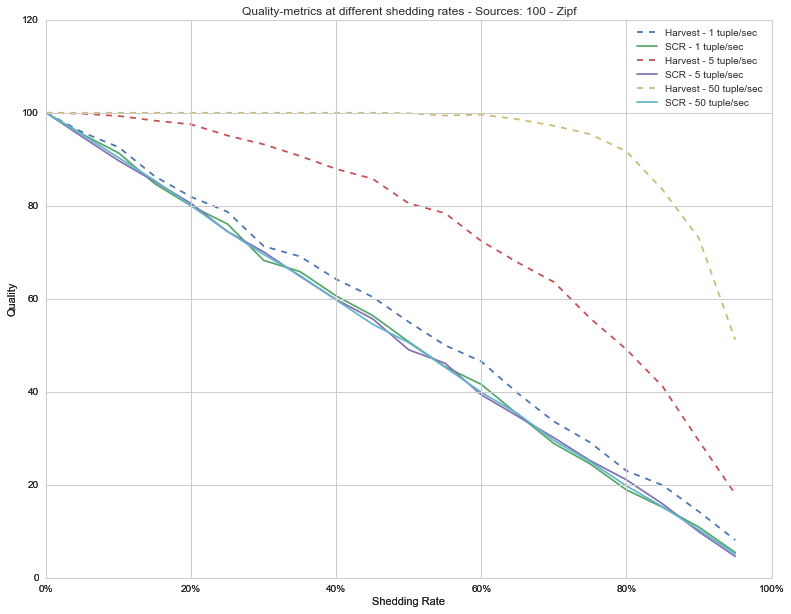

In [93]:
run_source_rate_distribution(array_zipf, 'Zipf')

### Conclusions

**Harvest** was defined in the context of large sensors deployment at low rate, it is meant to track *'the number of sources that contributed to a query result'.*  
It is better suited to measure the impact of tuple drop due to hardware failure or network communication. Reporting the total number of sources that cotributed to a result can be a good indicator of the working condition of the system. A high value indicates good confidence that the system is in good order and that the answer represents all of the input data sources. A perfect value of 100% though gives no confidence in the quality of the query result: even if at least one tuple from each source is received, a vast amount can still be missing. A low harvest value only indicates that the query answer should not be trusted, even if it potentially contains an almost perfect result.

**Source Coverage Ratio** was defined in the context of a constantly overloaded stream processing system to enable the *'quality-aware shedding of tuples'*.  
In this deployment the system operates under constant overload and needs to make informed decisions on what tuples to discard.
The SCR value of a tuple is inversly proportional to the source's rate during that interval. 
The total SCR value is an indication of what percentage of the source tuples went into the generation of the result.
The quality-aware shedder can decide that a high rate source probably produces a lot of relatively uninportant tuples, possibly just fast updates of similar values, and thus be more likely to drop the tuples with a low SCR value.
At the same time a tuples coming from a low rate source could be considered more valuable in order to preserve a large coverage of sources. 

In the performed experiments SCR closely follows the percentage of tuples dropped for all source rate distributions, while Harvest is highly dependant on the sources' rates. Harvest values are more similar to the drop rate when the tuple rate is low, a situation in which the two metrics are similar. Harvest is solely focused on sources, while SCR includes also the notion of tuple rate as an indication of the tuple contribution towards the query result.

